In [0]:
fifrom google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

from tqdm import tqdm

# model
import lightgbm as lgb

SEED=42
LABEL=None

In [0]:
path = '/content/drive/My Drive/bigcontest2019/'
os.chdir(path)

In [0]:
train_activity = pd.read_csv('data/train/train_activity.csv')
train_combat = pd.read_csv('data/train/train_combat.csv')
train_payment = pd.read_csv('data/train/train_payment.csv')
train_pledge = pd.read_csv('data/train/train_pledge.csv')
train_trade = pd.read_csv('data/train/train_trade.csv')

test1_activity = pd.read_csv('data/test/test1_activity.csv')
test1_combat = pd.read_csv('data/test/test1_combat.csv')
test1_payment = pd.read_csv('data/test/test1_payment.csv')
test1_pledge = pd.read_csv('data/test/test1_pledge.csv')
test1_trade = pd.read_csv('data/test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'data/test/test2_activity.csv')
test2_combat = pd.read_csv(path + 'data/test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'data/test/test2_payment.csv')
test2_pledge = pd.read_csv(path + 'data/test/test2_pledge.csv')
test2_trade = pd.read_csv(path + 'data/test/test2_trade.csv')

train_label = pd.read_csv('data/train/train_label.csv')

In [0]:
train_pledge.drop(['combat_play_time', 'non_combat_play_time'],axis=1,inplace=True)
test1_pledge.drop(['combat_play_time', 'non_combat_play_time'],axis=1,inplace=True)
test2_pledge.drop(['combat_play_time', 'non_combat_play_time'],axis=1,inplace=True)


train_activity.drop(['fishing'],axis=1,inplace=True)
test1_activity.drop(['fishing'],axis=1,inplace=True)
test2_activity.drop(['fishing'],axis=1,inplace=True)

In [0]:
class data_transform(object):
    def __init__(self, data):
        self.data = data
        
    def create_week(self):
        self.data['week'] = (self.data['day']-1)//7 + 1
        return self.data
    
    def activity_transform(self):
        temp_df = self.data
        groupby_dict = defaultdict()
        
        temp_df = pd.get_dummies(temp_df)
        
        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day' or feature == 'char_id':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = 'sum'
        else:        
            temp_df = temp_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
        
        return temp_df
    
    def payment_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = ['sum', 'count', 'max', 'std']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def trade_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        groupby_dict2 = defaultdict()
        
        output_df['time'] = output_df['time'].apply(lambda x: str(x)[:2])
        output_df[['time', 'type', 'server']] = output_df[['time', 'type', 'server']].astype(object)
        output_df = pd.get_dummies(output_df)
        output_df2 = output_df.copy()
        
        output_df = output_df.rename(columns={'source_acc_id':'acc_id'})
        output_df2 = output_df2.rename(columns={'target_acc_id':'acc_id'})
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'target_acc_id']:
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = 'sum'
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
        
        for feature in output_df2.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'source_acc_id']:
                groupby_dict2[feature] = 'nunique'
            else:
                groupby_dict2[feature] = 'sum'
        else:
            output_df2 = output_df2.groupby(['acc_id', 'week']).agg(groupby_dict2).reset_index()
        
        output_df = pd.merge(output_df, output_df2, how='left', on=['acc_id', 'week'])
        
        return output_df
    
    def combat_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server', 'class', 'level']] = output_df[['server', 'class', 'level']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = ['sum']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def pledge_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server']] = output_df[['server']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'pledge_id']:
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = 'sum'
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        return output_df
    
    
    
    def under_sampling(self):
        temp_df = self.data
        output_df = pd.DataFrame()
        for week in [1, 2, 3, 4]:
            _, under_sample = train_test_split(temp_df[(temp_df['week']==week) & (temp_df['survival_time']==64)], test_size=0.001, random_state=42, shuffle=True, 
                                               stratify=temp_df.loc[(temp_df['week']==week) & (temp_df['survival_time']==64), 'day'])
            output_df = pd.concat([output_df, under_sample]).reset_index(drop=True)
        
        return output_df
    
    def under_sampling2(self):
        temp_df = self.data
        _, under_sample = train_test_split(temp_df[(temp_df['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True)
#                                            stratify=temp_df.loc[(temp_df['survival_time']==64), 'daynunique'])
        
        return under_sample

# survival time

## train

### acitivity

In [0]:
transform = data_transform(train_activity)
transform.create_week()
train_act = transform.activity_transform()

### payment

In [0]:
transform = data_transform(train_payment)
transform.create_week()
train = transform.payment_transform()

### trade

In [0]:
trandform = data_transform(train_trade)
trandform.create_week()
train = trandform.trade_transform()

### combat

In [0]:
trandform = data_transform(train_combat)
trandform.create_week()
train = trandform.combat_transform()

### pledge

In [0]:
trandform = data_transform(train_pledge)
trandform.create_week()
train_pl = trandform.pledge_transform()

### merge

In [0]:
train = pd.merge(train_act.merge(train_com,how='left',on='acc_id').fillna(0),train_pl,how='left',on='acc_id').fillna(0)

## test

### activity

In [0]:
transform = data_transform(test1_activity)
transform.create_week()
test1_act = transform.activity_transform()

transform = data_transform(test2_activity)
transform.create_week()
test2_act = transform.activity_transform()

### payment

In [0]:
transform = data_transform(test1_payment)
transform.create_week()
test1 = transform.payment_transform()

transform = data_transform(test2_payment)
transform.create_week()
test2 = transform.payment_transform()

### trade

In [0]:
trandform = data_transform(test1_trade)
trandform.create_week()
test1 = trandform.combat_transform()

trandform = data_transform(test2_trade)
trandform.create_week()
test2 = trandform.combat_transform()

### combat

In [0]:
trandform = data_transform(test1_combat)
trandform.create_week()
test1 = trandform.combat_transform()

trandform = data_transform(test2_combat)
trandform.create_week()
test2 = trandform.combat_transform()

In [0]:
test2[test2['week']==4]

,acc_id,week,daynunique,char_idnunique,char_idsize,pledge_cntsum,random_attacker_cntsum,random_defender_cntsum,temp_cntsum,same_pledge_cntsum,etc_cntsum,num_opponentsum,server_aasum,server_absum,server_acsum,server_adsum,server_aesum,server_afsum,server_agsum,server_ahsum,server_aisum,server_ajsum,server_aksum,server_alsum,server_amsum,server_ansum,server_aosum,server_apsum,server_aqsum,server_arsum,server_assum,server_atsum,server_ausum,server_avsum,server_awsum,server_axsum,server_aysum,server_azsum,server_bbsum,server_bdsum,server_bjsum,server_bksum,server_blsum,server_bmsum,server_bnsum,server_bosum,server_bqsum,server_brsum,class_0sum,class_1sum,class_2sum,class_3sum,class_4sum,class_5sum,class_6sum,class_7sum,level_0sum,level_1sum,level_10sum,level_11sum,level_12sum,level_13sum,level_14sum,level_15sum,level_16sum,level_17sum,level_2sum,level_3sum,level_4sum,level_5sum,level_6sum,level_7sum,level_8sum,level_9sum
3,1,4,7,2,12,0.000000,0.000000,27.210483,0.000000,0.000000,4.391850,3.336378,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,7,0,0,0,0,0,0,0,0,0,0,0,0,7,0,5,0,0,0,0,0,0,0
7,3,4,4,2,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,2,0,2,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
9,9,4,3,4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
11,14,4,7,4,11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,0,7,2,0,0,1,0,0,1,0,7,0,0,0,0,0,0,0,0,0
15,26,4,7,2,11,13.093585,0.000000,1.183064,0.479728,6.199136,0.563058,16.485631,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,4,0,0,0,0,0,7,0,0,0,0,0,0,0,0
19,27,4,7,1,7,0.000000,0.000000,1.183064,0.000000,0.000000,0.112612,0.196258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0
23,32,4,7,2,14,1.861343,0.000000,13.013709,0.959456,0.000000,2.590065,1.668189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,7,0,0,0,0,0,0,0,0,0,0,0,7,0,0,7,0,0,0,0,0,4,3,0,7,0,0,0,0,0,0,0,0,0,0
27,44,4,6,1,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0
31,45,4,7,3,18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,5,6,0,0,0,0,0,0,0,0,0,0,0,12,6,0,0,0,0,0,0,0,0,0,6,12,0,0,0,0,0,0,0,0,0,0
35,49,4,7,7,29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,9,7,3,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,7


### pledge

In [0]:
trandform = data_transform(test1_pledge)
trandform.create_week()
test1_pl = trandform.pledge_transform()

trandform = data_transform(test2_pledge)
trandform.create_week()
test2_pl = trandform.pledge_transform()

In [0]:
test1 = pd.merge(test1_act.merge(test1_com,how='left',on='acc_id').fillna(0),test1_pl,how='left',on='acc_id').fillna(0)
test2 = pd.merge(test2_act.merge(test2_com,how='left',on='acc_id').fillna(0),test2_pl,how='left',on='acc_id').fillna(0)

In [0]:
train.shape, test1.shape, test2.shape

((1955436, 181), (885519, 169), (879526, 181))

## model

In [0]:
class model(object):
    def __init__(self, train_data, train_label, test1_data, test2_data, kind):
        self.train_data = train_data.fillna(0)
        self.train_label = train_label
        self.test1_data = test1_data.fillna(0)
        self.test2_data = test2_data.fillna(0)
        self.features_ = train_data.columns[train_data.columns.isin(list(set(train_data.columns) & set(test1_data.columns) & set(test2_data.columns)))].drop(['acc_id','week'])
        self.kind = kind
        
    def labeling(self):
        self.train_data = pd.merge(self.train_data, self.train_label[['acc_id', 'survival_time']], how='left', on='acc_id')
        self.train_data = self.train_data.dropna()
        for week in range(1, 5):
            self.train_data.loc[train['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
        
    def under_sampling(self):
        all_week_under_sample = pd.DataFrame()
        for week in range(1, 5):
            if self.kind == 'activity':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True, 
                                                   stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), 'day'])
            elif self.kind == 'payment':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True)
                
            elif self.kind == 'trade':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True,
                                                  stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), ['day_x', 'day_y']])
            elif self.kind == 'combat':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True,
                                                  stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), 'daynunique'])
            elif self.kind == 'pledge':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True,
                                                  stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), 'daynunique'])
                
            all_week_under_sample = pd.concat([all_week_under_sample, under_sample]).reset_index(drop=True)
        else:
            self.train_data = pd.concat([self.train_data[self.train_data['survival_time']!=64], all_week_under_sample]).reset_index(drop=True)
            
    def st_lgb_model(self, params, iteration, seed):
        
        LABEL='survival_time'
        train_df, valid_df = train_test_split(self.train_data, test_size=0.2, random_state=seed, shuffle=True, stratify=self.train_data[['week', LABEL]])
        
        trn_label = train_df[LABEL] - 1
        val_label = valid_df[LABEL] - 1
        ttt = lgb.Dataset(train_df[self.features_], label=trn_label)
        vvv = lgb.Dataset(valid_df[self.features_], label=val_label)

        lgb_model = lgb.train(params, ttt, iteration, valid_sets = [ttt, vvv], early_stopping_rounds = 50, verbose_eval=100)
        self.st_lgb_model = lgb_model
        
        preds_st = lgb_model.predict(self.test1_data.loc[self.test1_data['week']==4, self.features_].fillna(0))
        preds_st = np.argmax(preds_st, axis=1)+1

        preds_st2 = lgb_model.predict(self.test2_data.loc[self.test2_data['week']==4, self.features_].fillna(0))
        preds_st2 = np.argmax(preds_st2, axis=1)+1
        
        preds_st = pd.concat([self.test1_data.loc[self.test1_data['week']==4, 'acc_id'].reset_index(drop=True), pd.DataFrame(preds_st, columns=['survival_time'])], 1)
        preds_st2 = pd.concat([self.test2_data.loc[self.test2_data['week']==4, 'acc_id'].reset_index(drop=True), pd.DataFrame(preds_st2, columns=['survival_time'])], 1)
    
        return preds_st, preds_st2
    
    def feature_importance(self):
        feature_imp = pd.DataFrame(sorted(zip(self.st_lgb_model.feature_importance(), self.features_)), columns=['Value','Feature'])
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.show()

In [0]:
PARAMS = {
    'objective':'multiclass',
    'num_class':64,
    "boosting": "gbdt",
    'learning_rate': 0.03,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'seed':SEED
}

# 주의!! model object 마지막 kinds arguments 명시해줄것!!
model_ = model(train, train_label, test1, test2, 'combat')
model_.labeling()
model_.under_sampling()
preds_st, preds_st2 = model_.st_lgb_model(PARAMS, 100, SEED)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 3.42329	valid_1's multi_logloss: 3.68099
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 3.42329	valid_1's multi_logloss: 3.68099


In [0]:
# activity + combat + pledge : iter 100
model_.feature_importance()

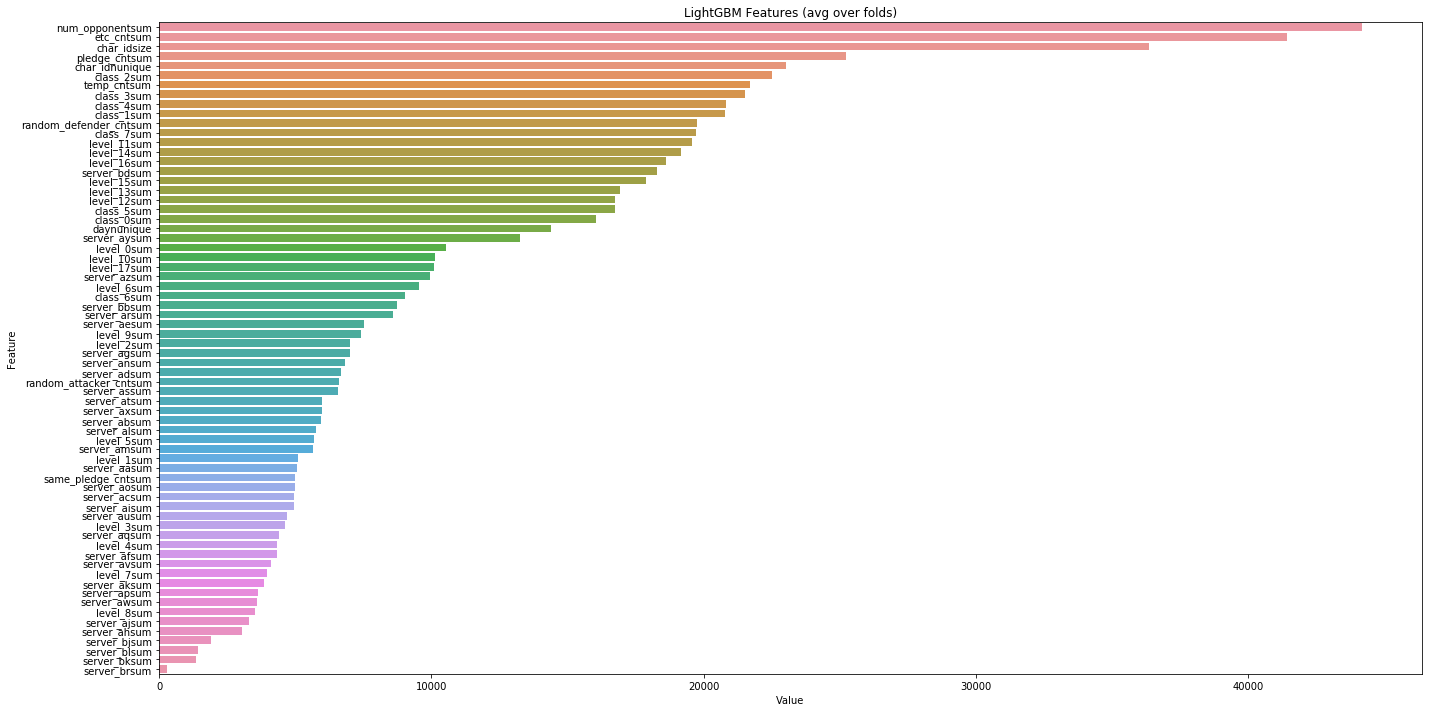

In [0]:
# combat
# model_.feature_importance()

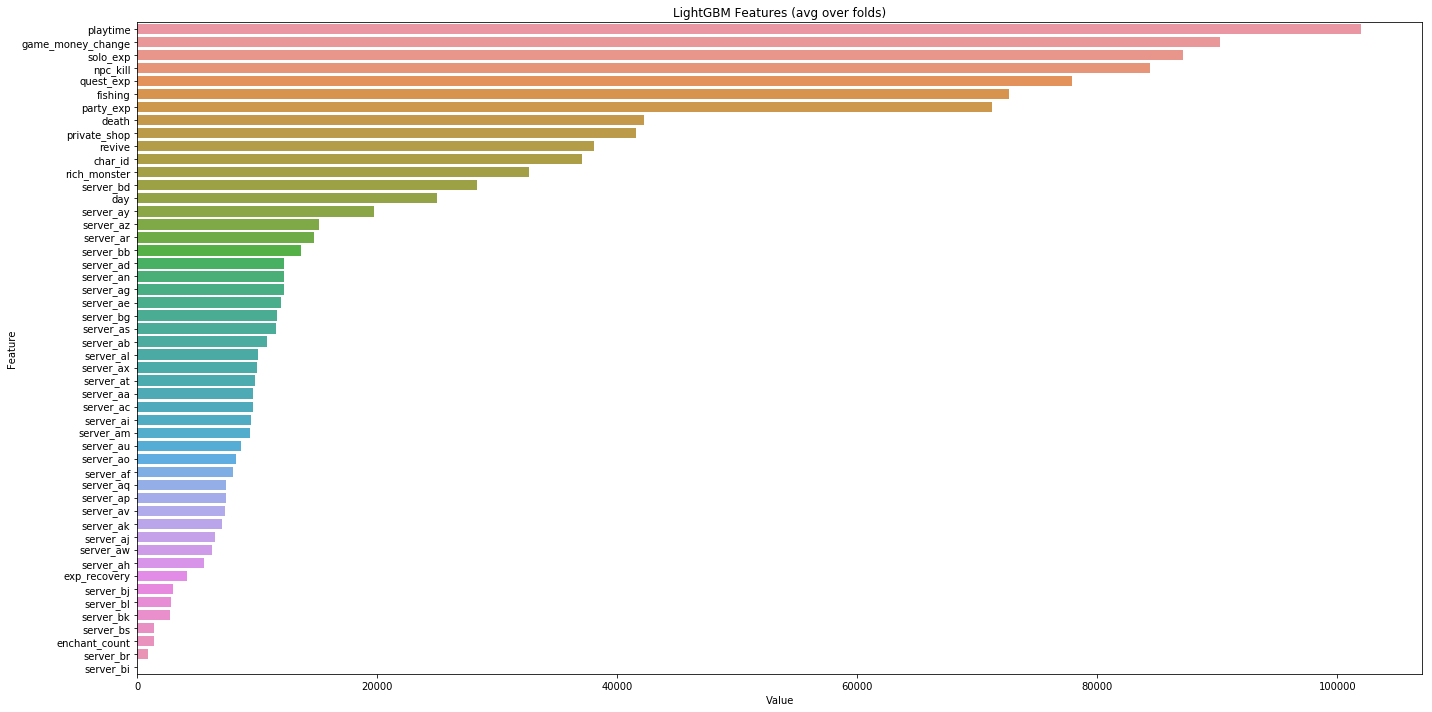

In [0]:
# activity
# model_.feature_importance() 

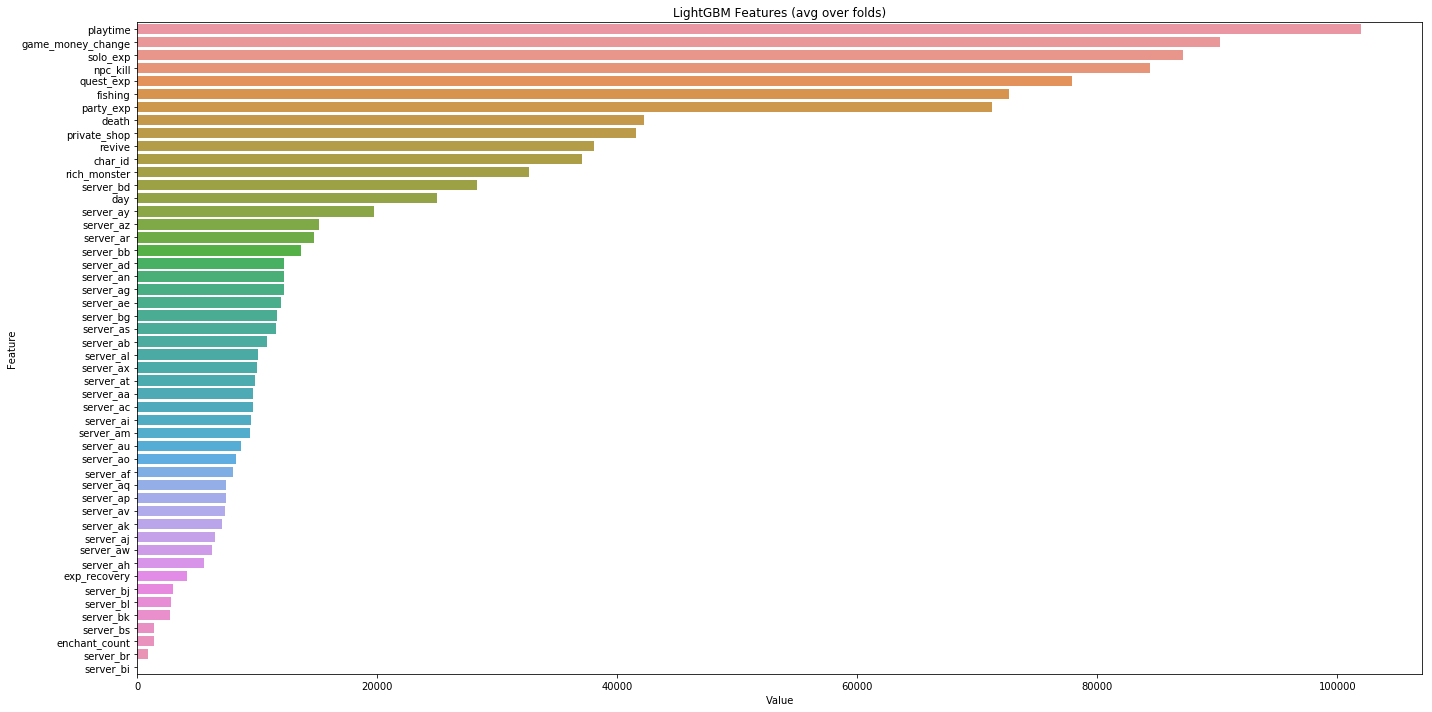

In [0]:
#pledge
model_.feature_importance()

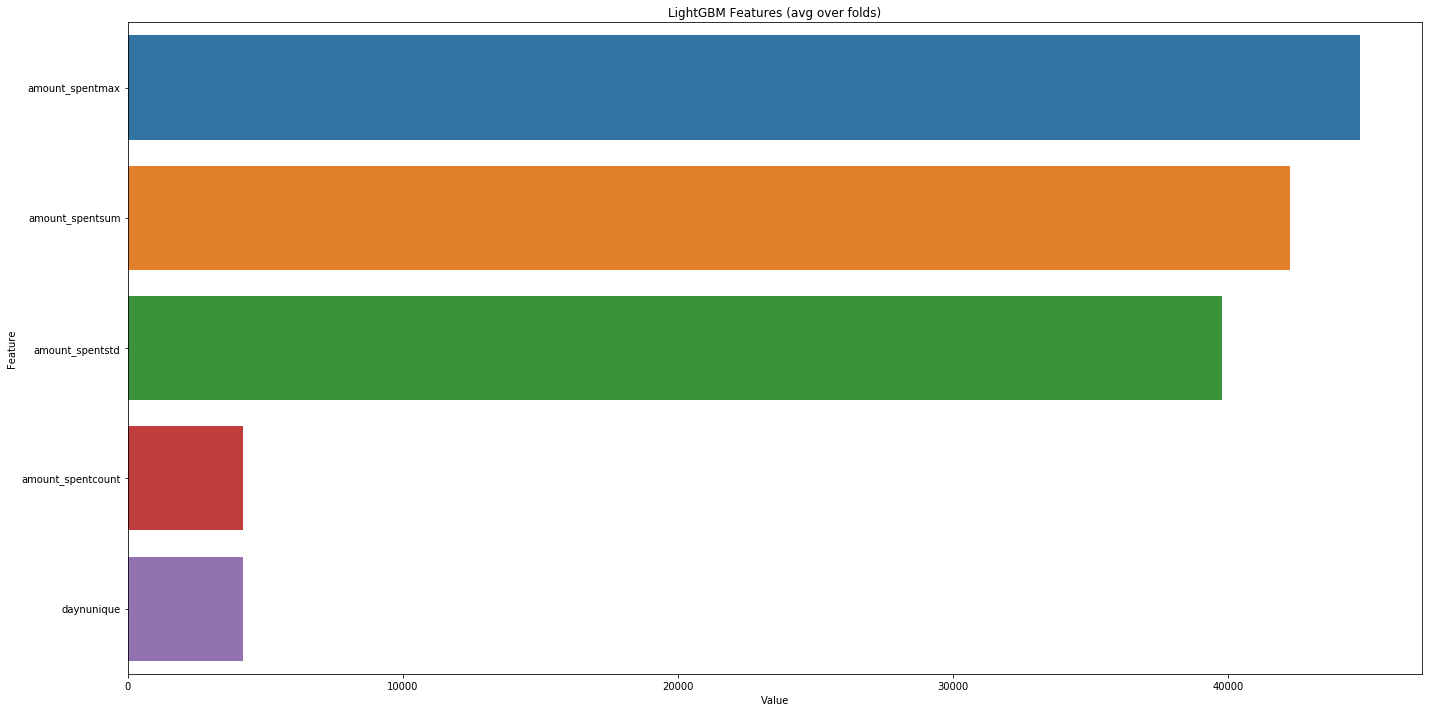

In [0]:
# payment
model_.feature_importance()

# amount spent

In [0]:
# train_label[train_label['survival_time']!=64]

In [0]:
# from sklearn.model_selection import KFold

# train_label['amount_spent_round'] = np.round(train_label['amount_spent'], 2)

# # preds_spent1= np.zeros(len(test1[test1['week']==4]))
# # preds_spent2 = np.zeros(len(test2[test2['week']==4]))
# oof_spent = pd.DataFrame(columns=['acc_id','oof'])

# preds_spent1 = defaultdict()
# preds_spent2 = defaultdict()

# kf = KFold(n_splits=5,random_state=42)

# for SEED in range(1,101):
#     stack_df = pd.DataFrame()
#     np.random.seed(SEED)


#     for as_round in train_label['amount_spent_round'].unique():
#         temp_df = train_label[train_label['amount_spent_round']==as_round]
#         try:
#             idx = np.random.choice(temp_df.index, 3, replace=False)
#             temp_df = temp_df.loc[idx]
#         except:
#             pass
#         stack_df = pd.concat([stack_df, temp_df])
    
#     idx_lst = stack_df['acc_id']
#     stack_oof = np.zeros(len(stack_df))
#     stack_preds1 = np.zeros(len(preds_st))
#     stack_preds2 = np.zeros(len(preds_st2))

#     for trn_idx,val_idx in kf.split(stack_df):
#         train_df = stack_df['survival_time'].reset_index(drop=True)
#         label_df = stack_df['amount_spent'].reset_index(drop=True)

#         rf = RandomForestRegressor(n_estimators=100).fit(train_df[trn_idx].values.reshape(-1,1), label_df[trn_idx].values.ravel()))
        
#         stack_oof[val_idx] = rf.predict(train_df[val_idx].values.reshape(-1,1))
        
#         stack_preds1 += rf.predict(preds_st['survival_time'].values.reshape(-1,1))/kf.n_splits
#         stack_preds2 += rf.predict(preds_st2['survival_time'].values.reshape(-1,1))/kf.n_splits
    
#     tmp_oof = pd.DataFrame({'acc_id':idx_lst,'amount_spent': stack_oof})
#     oof_spent = oof_spent.append(tmp_oof)

#     preds_spent1[str(SEED)] = stack_preds1
#     preds_spent2[str(SEED)] = stack_preds2


In [0]:
preds_st

,acc_id,survival_time
0,7,29
1,15,36
2,16,1
3,18,29
4,19,43
5,22,43
6,24,29
7,28,29
8,39,29
9,51,29


In [0]:
from sklearn.model_selection import KFold

train_label['amount_spent_round'] = np.round(train_label['amount_spent'], 2)

oof_spent = pd.DataFrame()

preds_spent1 = defaultdict()
preds_spent2 = defaultdict()
i=0
kf = KFold(n_splits=5,random_state=42,shuffle=True)

for trn_idx,val_idx in kf.split(train_label):
    stack_oof = pd.DataFrame()
    i+=1
    for SEED in range(1,11):
        stack_df = pd.DataFrame()
        np.random.seed(SEED)

        for as_round in train_label['amount_spent_round'].unique():
            temp_df = train_label[train_label['amount_spent_round']==as_round]
            try:
                idx = np.random.choice(temp_df.index, 3, replace=False)
                temp_df = temp_df.loc[idx]
            except:
                pass
            stack_df = pd.concat([stack_df, temp_df])
        
        idx_lst = stack_df['acc_id']
        
        stack_preds1 = np.zeros(len(preds_st))
        stack_preds2 = np.zeros(len(preds_st2))

        train_df = stack_df['survival_time'].reset_index(drop=True)
        label_df = stack_df['amount_spent'].reset_index(drop=True)
        val_df = train_label['survival_time'].reset_index(drop=True)

        rf = RandomForestRegressor(n_estimators=100).fit(train_df.values.reshape(-1,1), label_df.values.ravel())

        stack_oof['val_idx'] = val_idx        
        stack_oof['model_'+str(SEED)] = rf.predict(val_df[val_idx].values.reshape(-1,1))


        stack_preds1 += rf.predict(preds_st['survival_time'].values.reshape(-1,1))/kf.n_splits
        stack_preds2 += rf.predict(preds_st2['survival_time'].values.reshape(-1,1))/kf.n_splits

        preds_spent1['model_'+str(i)+str(SEED)] = stack_preds1
        preds_spent2['model_'+str(i)+str(SEED)] = stack_preds2

    oof_spent = pd.concat([oof_spent,stack_oof],axis=0)

In [0]:
 oof_spent_1 = oof_spent.sort_values(by='val_idx').drop('val_idx',axis=1)

In [0]:
oof_spent_1

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10
0,0.331986,0.330740,0.337399,0.345922,0.329530,0.343177,0.348326,0.317064,0.354790,0.359369
0,0.331986,0.330740,0.337399,0.345922,0.329530,0.343177,0.348326,0.317064,0.354790,0.359369
0,0.124007,0.230532,0.244782,0.384310,0.333487,0.378280,0.642065,0.208036,0.244683,0.194470
0,0.331986,0.330740,0.337399,0.345922,0.329530,0.343177,0.348326,0.317064,0.354790,0.359369
1,0.911987,0.855183,0.654962,0.684930,0.591184,0.932155,0.766403,1.035223,0.585052,0.773970
1,0.268975,0.557872,0.543862,0.705338,0.225362,0.177054,0.464594,0.363749,0.092021,0.512786
1,0.331986,0.330740,0.337399,0.345922,0.329530,0.343177,0.348326,0.317064,0.354790,0.359369
2,2.600702,2.520371,2.533635,2.631302,2.735088,2.536547,2.719133,2.605128,2.440593,2.718386
2,0.219858,0.298304,0.582096,0.128054,0.403363,0.263718,0.499474,0.152316,0.242068,0.616555
0,0.924416,1.146232,1.160091,0.990379,1.056398,1.124848,1.106929,0.947464,1.125099,0.997822


In [0]:
oof_spent_1.to_csv('/content/oof_spent.csv')

In [0]:
oof_spent.describe()

,val_idx,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10
count,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,19999.50000,0.885821,0.899214,0.898044,0.894867,0.897362,0.897258,0.925020,0.891045,0.889916,0.912019
std,11547.14972,1.376981,1.403467,1.386998,1.348111,1.382233,1.386760,1.353046,1.406025,1.397178,1.408277
min,0.00000,0.083753,0.196225,0.114433,0.128054,0.143979,0.137270,0.134149,0.117613,0.072751,0.043401
25%,9999.75000,0.331986,0.330740,0.337399,0.345922,0.329530,0.343177,0.348326,0.317064,0.354790,0.359369
50%,19999.50000,0.331986,0.330740,0.337399,0.345922,0.329530,0.343177,0.348326,0.317064,0.354790,0.359369
75%,29999.25000,0.951103,0.855183,0.883437,0.898084,0.930121,0.857218,1.002572,0.923273,0.885133,0.946655
max,39999.00000,8.140454,8.226225,8.086199,7.867371,8.225830,8.165146,7.958460,8.298256,8.207259,8.362137


### HH's work

In [0]:
def add_week(activity):
  activity['week'] = ((activity['day']-1)//7)+1
  
  return activity

In [0]:
train_pay_week = add_week(train_payment)
test1_pay_week = add_week(test1_payment)
test2_pay_week = add_week(test2_payment)

train_pay_week.head()

,day,acc_id,amount_spent,week
0,18,27835,0.826123,3
1,23,27835,0.011735,4
2,27,27835,0.035204,4
3,17,12351,0.528062,3
4,11,125437,0.633674,2


In [0]:
train_payment_by_week = train_payment.groupby(['acc_id', 'week']).sum()['amount_spent'].reset_index().rename(columns = {'amount_spent':'payment'})
test1_payment_by_week = test1_payment.groupby(['acc_id', 'week']).sum()['amount_spent'].reset_index().rename(columns = {'amount_spent':'payment'})
test2_payment_by_week = test2_payment.groupby(['acc_id', 'week']).sum()['amount_spent'].reset_index().rename(columns = {'amount_spent':'payment'})

train_payment_by_week.head()

,acc_id,week,payment
0,8,1,1.056123
1,8,4,0.348521
2,20,2,0.070408
3,20,3,0.826123
4,21,3,2.346940


In [0]:
def add_label2(activity_by_week):
  # merge
  activity_stack = pd.merge(activity_by_week, train_label, on='acc_id', how='left')
  activity_stack['total_spent'] = activity_stack['survival_time'] * activity_stack['amount_spent']
  # survival time plus
  for i in range(1, 5):
    activity_stack.loc[activity_stack['week'] == i, 'survival_time'] = np.minimum(64, activity_stack.loc[activity_stack['week'] == i] + (7*(4-i)))
  #activity_stack
  
  return activity_stack

In [0]:
train_pay_label = add_label2(train_payment_by_week)
train_pay_label.head()

,acc_id,week,payment,survival_time,amount_spent,amount_spent_round,total_spent
0,8,1,1.056123,64.0,0.020310,0.02,1.299843
1,8,4,0.348521,64.0,0.020310,0.02,1.299843
2,20,2,0.070408,64.0,0.052137,0.05,3.336752
3,20,3,0.826123,64.0,0.052137,0.05,3.336752
4,21,3,2.346940,64.0,0.184267,0.18,11.793078


In [0]:
def change_amount_spent(pay_label):
  pay_lags = pd.concat([pay_label, 
                        pay_label.groupby('acc_id').shift(-1).reset_index().rename(columns={'payment':'lead1'})['lead1'], 
                        pay_label.groupby('acc_id').shift(-2).reset_index().rename(columns={'payment':'lead2'})['lead2'],
                        pay_label.groupby('acc_id').shift(-3).reset_index().rename(columns={'payment':'lead3'})['lead3']], axis=1)
  pay_lags['lead_sum'] = pay_lags['lead1'].fillna(0) + pay_lags['lead2'].fillna(0)
  
  for i in range(1, 5):
    pay_lags.loc[(pay_lags['week'] == i) & (pay_lags['survival_time'] == 64), 'total_spent'] = (pay_lags.loc[(pay_lags['week'] == i) & (pay_lags['survival_time'] == 64), 'total_spent']/64) * (71 - (7*i)) + pay_lags.loc[(pay_lags['week'] == i) & (pay_lags['survival_time'] == 64), 'lead_sum']
  pay_lags.loc[pay_lags['survival_time'] != 64, 'total_spent'] = pay_lags.loc[pay_lags['survival_time'] != 64, 'total_spent'] + pay_lags.loc[pay_lags['survival_time'] != 64, 'lead_sum']
  pay_lags['amount_spent'] = pay_lags['total_spent'] / pay_lags['survival_time']
  pay_lags = pay_lags[['acc_id', 'week', 'survival_time', 'amount_spent', 'total_spent']]

  return pay_lags

In [0]:
change_amount_spent(train_pay_label).head()

,acc_id,week,survival_time,amount_spent,total_spent
0,8,1,64.0,0.025756,1.648363
1,8,4,64.0,0.013646,0.873332
2,20,2,64.0,0.059342,3.797918
3,20,3,64.0,0.040732,2.606838
4,21,3,64.0,0.149404,9.561863


In [0]:
change_amount_spent(train_pay_label)

,acc_id,week,survival_time,amount_spent,total_spent
0,8,1,64.0,0.025756,1.648363
1,8,4,64.0,0.013646,0.873332
2,20,2,64.0,0.059342,3.797918
3,20,3,64.0,0.040732,2.606838
4,21,3,64.0,0.149404,9.561863
5,21,4,64.0,0.123804,7.923475
6,38,1,64.0,0.608845,38.966087
7,38,2,64.0,0.543112,34.759178
8,38,4,64.0,0.347472,22.238213
9,41,4,3.0,0.000000,0.000000


# submission

In [0]:
test1_pred = pd.concat([test1_week['acc_id'], pd.DataFrame(preds, columns=['survival_time']), pd.DataFrame(preds_spent*25, columns=['amount_spent'])], 1)
test1_pred.to_csv('/content/test1_predict.csv', index=False)

In [0]:
test2_pred = pd.concat([test2_week['acc_id'], pd.DataFrame(preds2, columns=['survival_time']), pd.DataFrame(preds2_spent*10, columns=['amount_spent'])], 1)
test2_pred.to_csv('/content/test2_predict.csv', index=False)

In [0]:
test1_pred = pd.concat([test1[test1['week']==4]['acc_id'].reset_index(drop=True), pd.DataFrame(preds_st, columns=['survival_time']), pd.DataFrame(preds_spent, columns=['amount_spent'])], 1)
test1_pred.to_csv('/content/test1_predict.csv', index=False)

In [0]:
test2_pred = pd.concat([test2[test2['week']==4]['acc_id'].reset_index(drop=True), pd.DataFrame(preds_st2, columns=['survival_time']), pd.DataFrame(preds_spent2, columns=['amount_spent'])], 1)
test2_pred.to_csv('/content/test2_predict.csv', index=False)